### Import Packages

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Create output function

In [2]:
def output(w, a, b):
    return np.dot(a, w) + np.sum(b)

In [3]:
def d_output_w(a):
    return np.transpose(a)

In [4]:
def d_output_b(a):
    return np.transpose(np.ones(a.shape[0]))

### Create Activation Functions

In [40]:
def sigmoid(z, extra_param = None):
    return np.exp(z) / (1 + np.exp(z))

In [41]:
def d_sigmoid(z, extra_param = None):
    return sigmoid(z) * (1 - sigmoid(z))

In [42]:
def tanh(z, extra_param = None):
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

In [43]:
def d_tanh(z, extra_param = None):
    return 1 - tanh(z) ** 2

In [44]:
def relu(z, extra_param = None):
    return z * (z > 0)

In [45]:
def d_relu(z, extra_param = None):
    return 1 * (z > 0)

In [46]:
def relu6(z, extra_param = None):
    return z * (z > 0) + (6 - z) * (z > 6)

In [47]:
def d_relu6(z, extra_param = None):
    return 1 * (z > 0) * (z < 6)

In [11]:
def leaky_relu(z, alpha):
    return z * (z > 0) + (alpha * z) * (z <= 0)

In [36]:
def d_leaky_relu(z, alpha):
    return 1 * (z > 0) - alpha * (z < 0)

In [473]:
def softmax(z, extra_param = None):
    sums = np.dot(np.transpose(np.sum(np.exp(z), axis = 1).reshape(1, -1)), np.ones([1, z.shape[1]]))
    return np.exp(z) / sums

In [393]:
def d_softmax(z, extra_param = None):
    # Using this to return 1 since both parts of this gradient are calculated in the d_loss function
    return 1

### Create Loss Functions

In [366]:
def mse(y, a):
    return np.mean(.5 * (y.reshape(-1, 1) - a) ** 2)

In [13]:
def d_mse(y, a):
    return (a - y.reshape(-1, 1))

In [367]:
def binary_cross_ent(y, a):
    return np.mean(-1 * y * np.log(a) - (1 - y) * np.log(1 - a))

In [341]:
def d_binary_cross_ent(y, a):
    return -1 * y / a + (1 - y) / (1 - a)

In [458]:
def cross_entropy(y, a):
    return np.mean(-1 * np.sum(y * np.log(a), axis = 1))

In [394]:
def d_cross_entropy(y, a):
    return a - y

### Create Neural Network Class

In [488]:
class NeuralNet:
    
    def __init__(self, X, y, hidden_layer_nodes, output_layer_nodes, act_fn, d_act_fn,
                 final_act_fn, d_final_act_fn, loss_fn, d_loss_fn, random_state, alpha = None):
        
        self.X = X
        self.y = y
        self.alpha = alpha
        
        self.hidden_layer_nodes = hidden_layer_nodes
        self.output_layer_nodes = output_layer_nodes
        
        self.act_fn = act_fn
        self.d_act_fn = d_act_fn
        self.final_act_fn = final_act_fn
        self.d_final_act_fn = d_final_act_fn
        self.loss_fn = loss_fn
        self.d_loss_fn = d_loss_fn
        
        self.layers = []
        self.losses = np.array([])
        
        # Create First Layer
        self.layers.append(Layer(self.act_fn, self.d_act_fn, self.hidden_layer_nodes[0],
                                 self.X.shape[1], X, 0, alpha, False))
        
        # Create Hidden Layers
        for i in range(1, 1 + len(self.hidden_layer_nodes)):
            if i == len(self.hidden_layer_nodes):
                # Create final node - skip to below
                break
            else:
                self.layers.append(Layer(self.act_fn, self.d_act_fn, self.hidden_layer_nodes[i],
                                         self.layers[i - 1].nodes, self.layers[i - 1].outputs, 0, alpha, False))

        # Create Final Layer
        self.layers.append(Layer(self.final_act_fn, self.d_final_act_fn, self.output_layer_nodes,
                                self.layers[-1].nodes, self.layers[-1].outputs, 0, alpha, True, loss_fn, d_loss_fn, y))
        
    def train(self, eta, epochs):
        self.eta = eta
        self.epochs = epochs
        
        for i in range(self.epochs):
            if i % 100 == 0:
                self.losses = np.append(self.losses, self.get_loss())
            self.forward_prop()
            self.backward_prop()
    
    def forward_prop(self):
        self.layers[0].set_activations(self.X)
        self.layers[0].forward_prop()
        
        for i in range(1, len(self.layers)):
            self.layers[i].set_activations(self.layers[i - 1].outputs)
            self.layers[i].forward_prop()
    
    def backward_prop(self):
        # Final layer first
        self.layers[-1].backward_prop(self.eta)
        
        for i in range(len(self.layers) - 2, -1, -1):
            self.layers[i].backward_prop(self.eta, self.layers[i + 1].d_w,
                                         self.layers[i + 1].d_b, self.layers[i + 1].weights)
        
    def get_loss(self):
        return self.loss_fn(self.y, self.layers[-1].outputs)
    
    def predict(self, new_X):
        outputs = new_X
        for layer in self.layers:
            outputs = layer.predict(outputs)
        return outputs

### Create Layer Class

In [444]:
class Layer:
    
    def __init__(self, act_fn, d_act_fn, nodes, nodes_prev, activations, random_state, alpha,
                 is_final, loss_fn = None, d_loss_fn = None, y = None):
        self.act_fn = act_fn
        self.d_act_fn = d_act_fn
        self.nodes = nodes
        self.nodes_prev = nodes_prev 
        self.is_final = is_final
        self.loss_fn = loss_fn
        self.d_loss_fn = d_loss_fn
        self.y = y
        self.alpha = alpha
        
        np.random.seed(random_state)
        self.weights = np.random.random(size = [self.nodes_prev, self.nodes]) * 2 - 1
        self.biases = np.random.random(size = [self.nodes]) * 2 - 1
        self.activations = activations
        
        self.weighted_inputs = self.get_weighted_inputs()
        self.outputs = self.calc_outputs()
        
    def output(self, w, a, b):
        return np.dot(a, w) + np.sum(b)
    
    def d_output_w(self, a):
        return np.transpose(a)
    
    def set_activations(self, activations):
        self.activations = activations
        
    def get_weighted_inputs(self):
        return self.output(self.weights, self.activations, self.biases)
    
    def calc_outputs(self):
        return self.act_fn(self.weighted_inputs, self.alpha)
    
    def forward_prop(self):
        self.weighted_inputs = self.get_weighted_inputs()
        self.outputs = self.calc_outputs()
    
    def get_weight_deltas(self, d_w_next = None, w_next = None):
        if self.is_final:
            return self.d_loss_fn(self.y, self.outputs) * self.d_act_fn(self.weighted_inputs, self.alpha)
        else:
             return np.dot(d_w_next, np.transpose(w_next)) * self.d_act_fn(self.weighted_inputs, self.alpha)
        
    def get_bias_deltas(self, d_b_next = None, w_next = None):
        if self.is_final:
            return self.d_w
        else:
            return np.dot(d_b_next, np.transpose(w_next)) * self.d_act_fn(self.weighted_inputs, self.alpha)
            
    
    def backward_prop(self, eta, d_w_next = None, d_b_next = None, w_next = None):
        self.d_w = self.get_weight_deltas(d_w_next, w_next)
        self.d_b = self.get_bias_deltas(d_b_next, w_next)
        
        self.weights = self.weights - eta * np.dot(self.d_output_w(self.activations), self.d_w)
        self.biases = self.biases - eta * np.sum(self.d_b, axis = 0)

    
    def predict(self, new_X):
        return self.act_fn(self.output(self.weights, new_X, self.biases), self.alpha)


### Initialize Regression Data

In [495]:
boston = datasets.load_boston()
X = boston['data']
y = boston['target']

X_scaler = StandardScaler().fit(X)
X = X_scaler.transform(X)

y_scaler = MinMaxScaler((0, 1)).fit(y.reshape(-1, 1))
y = y_scaler.transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 0)

### Create and Train Neural Net

In [496]:
nn1 = NeuralNet(X_train, y_train, [8], 1, sigmoid, d_sigmoid, sigmoid, d_sigmoid,
                mse, d_mse, random_state = 0)
nn1.train(eta = .01, epochs = 20000)

preds1 = nn1.predict(X_test)
rmse1 = np.sqrt(np.mean((y_scaler.inverse_transform(y_test) - y_scaler.inverse_transform(preds1)) ** 2))
rmse1

3.770101152882372

### Compare Activation Functions

6.819162610211857 5.99203608274016 5.897227304208365 5.897227304208365 5.768210641844075


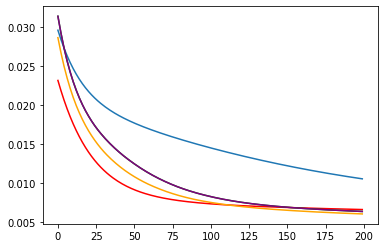

In [497]:
nn1 = NeuralNet(X_train, y_train, [4], 1, sigmoid, d_sigmoid, sigmoid, d_sigmoid,
                mse, d_mse, random_state = 1)
nn1.train(eta = .00001, epochs = 20000)

nn2 = NeuralNet(X_train, y_train, [4], 1, tanh, d_tanh, sigmoid, d_sigmoid,
                mse, d_mse, random_state = 1)
nn2.train(eta = .00001, epochs = 20000)

nn3 = NeuralNet(X_train, y_train, [4], 1, relu, d_relu, sigmoid, d_sigmoid,
                mse, d_mse, random_state = 1)
nn3.train(eta = .00001, epochs = 20000)

nn4 = NeuralNet(X_train, y_train, [4], 1, relu6, d_relu6, sigmoid, d_sigmoid,
                mse, d_mse, random_state = 1)
nn4.train(eta = .00001, epochs = 20000)

nn5 = NeuralNet(X_train, y_train, [4], 1, leaky_relu, d_leaky_relu, sigmoid, d_sigmoid,
                mse, d_mse, random_state = 1, alpha = .1)
nn5.train(eta = .00001, epochs = 20000)


# plt.ylim([0, 10])
plt.plot(nn1.losses)
plt.plot(nn2.losses, color = 'red')
plt.plot(nn3.losses, color = 'green')
plt.plot(nn4.losses, color = 'purple')
plt.plot(nn5.losses, color = 'orange')

preds1 = nn1.predict(X_test)
preds2 = nn2.predict(X_test)
preds3 = nn3.predict(X_test)
preds4 = nn4.predict(X_test)
preds5 = nn5.predict(X_test)

rmse1 = np.sqrt(np.mean((y_scaler.inverse_transform(y_test) - y_scaler.inverse_transform(preds1)) ** 2))
rmse2 = np.sqrt(np.mean((y_scaler.inverse_transform(y_test) - y_scaler.inverse_transform(preds2)) ** 2))
rmse3 = np.sqrt(np.mean((y_scaler.inverse_transform(y_test) - y_scaler.inverse_transform(preds3)) ** 2))
rmse4 = np.sqrt(np.mean((y_scaler.inverse_transform(y_test) - y_scaler.inverse_transform(preds4)) ** 2))
rmse5 = np.sqrt(np.mean((y_scaler.inverse_transform(y_test) - y_scaler.inverse_transform(preds5)) ** 2))

print(rmse1, rmse2, rmse3, rmse4, rmse5)

### Initialize Binary Classification Data

In [492]:
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer['data']
y = breast_cancer['target'].reshape(-1, 1)

X_scaler = StandardScaler().fit(X)
X = X_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 0)

0.9707602339181286 0.9766081871345029 0.9824561403508771


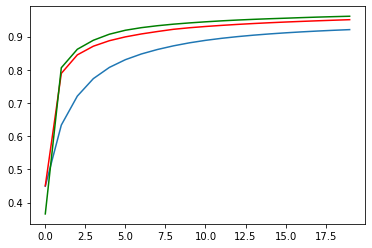

In [493]:
nn1 = NeuralNet(X_train, y_train, [8], 1, sigmoid, d_sigmoid, sigmoid, d_sigmoid,
                binary_cross_ent, d_binary_cross_ent, random_state = 0)

nn1.train(eta = .0001, epochs = 2000)

nn2 = NeuralNet(X_train, y_train, [8], 1, tanh, d_tanh, sigmoid, d_sigmoid,
                binary_cross_ent, d_binary_cross_ent, random_state = 0)

nn2.train(eta = .0001, epochs = 2000)

nn3 = NeuralNet(X_train, y_train, [8], 1, relu, d_relu, sigmoid, d_sigmoid,
                binary_cross_ent, d_binary_cross_ent, random_state = 0)

nn3.train(eta = .0001, epochs = 2000)

# plt.ylim([0, np.max(nn1.losses) * 1.1])
plt.plot(np.exp(-1 * nn1.losses))
plt.plot(np.exp(-1 * nn2.losses), color = 'red')
plt.plot(np.exp(-1 * nn3.losses), color = 'green')

preds1 = nn1.predict(X_test)
preds2 = nn2.predict(X_test)
preds3 = nn3.predict(X_test)

accuracy1 = np.mean(np.round(preds1) == y_test)
accuracy2 = np.mean(np.round(preds2) == y_test)
accuracy3 = np.mean(np.round(preds3) == y_test)

print(accuracy1, accuracy2, accuracy3)

### Initialize Multi-Class Classification Data

In [489]:
digits = datasets.load_digits()
X = digits['data']
y = digits['target']

X_scaler = StandardScaler().fit(X)
X = X_scaler.transform(X)

y_onehot = np.zeros([len(y), len(np.unique(y))])

for i in range(len(y)):
    y_onehot[i, y[i]] = 1

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size = .3, random_state = 0)

0.9898148148148148


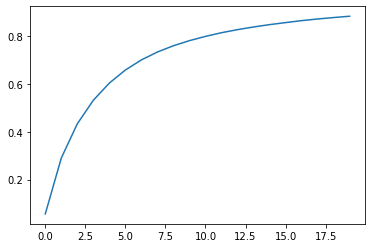

In [490]:
nn1 = NeuralNet(X_train, y_train, [16], y_train.shape[1], sigmoid, d_sigmoid, softmax, d_softmax,
                cross_entropy, d_cross_entropy, random_state = 0)

nn1.train(eta = .0001, epochs = 2000)

plt.plot(np.exp(-1 * nn1.losses))

print(np.mean(np.round(nn1.predict(X_test)) == y_test))
